In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from matplotlib import patches
from scipy.stats import norm, invgamma, multivariate_normal
import corner

## Q1. In the 11th dataset from pset02, do an MCMC to sample for five amplitudes $A_1, A_2, A_3, A_4, B$ and period $T_1$
## Remember, fit is of type <font color='blue'>$ A_1 cos(2\pi t/T_0) + A_2 sin(2\pi t/T_0) + A_3 cos(2\pi t/T_1) + A_4 sin(2\pi t/T_1) + B$ </font>

In [4]:
df = pd.read_pickle("./data.pkl") 
X_data = df[:,0]
Y_data_err = df[:,1]
Y_data = df[:,-1]

T0 = 100
def sinusoidal(t, A1, A2, A3, A4, B, T1):
    pi = np.pi
    return A1*np.cos(2*pi*t/T0) + A2*np.sin(2*pi*t/T0) + A3*np.cos(2*pi*t/T1) + A4*np.sin(2*pi*t/T1) + B

def log_LL(X, Y, Y_err, pars):
    A1, A2, A3, A4, B, T1 = pars[0], pars[1], pars[2], pars[3], pars[4], pars[5]
    Y_fit = [sinusoidal(t, A1, A2, A3, A4, B, T1) for t in X]
    ans = -1/2*np.sum((Y[i]-Y_fit[i])**2/(Y_err[i])**2 for i in range(len(X)))
    return ans

#we want to set priors on the amplitudes and on period.
def log_prior(pars): 
    #for amplitudes and period, use normal distributions, and set variance somewhat large
    #broad priors is better than narrow priors
    pars0, pars1, pars2, pars3, pars4, pars5 = pars[0], pars[1], pars[2], pars[3], pars[4], pars[5]
    A1, A2, A3, A4 = norm(0,10), norm(0,10), norm(0,10), norm(0,10) 
    B = norm(0,5)
    T1 = norm(0,500)
    return np.log(A1.pdf(pars0) * A2.pdf(pars1) * A3.pdf(pars2) * A4.pdf(pars3) * B.pdf(pars4) * T1.pdf(pars5))

In [27]:
pars_list = []
N = 50000
pars = np.array([0,0,0,0,0,200])

i = 0
while i<N:
    pars_prime = multivariate_normal(pars, 2*np.identity(6)).rvs()
    r = np.random.uniform() 
    Q = log_prior(pars_prime) + log_LL(X_data, Y_data, Y_data_err, pars_prime) #proposed distribution
    previous = log_prior(pars) + log_LL(X_data, Y_data, Y_data_err, pars)
    xi = np.min((np.exp(Q-previous),1))
    if xi>r:
        pars = pars_prime
    pars_list.append(pars)
    i += 1
samples = np.vstack(pars_list)

C:\Users\ajati\AppData\Local\Temp\ipykernel_20188\3149591842.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  ans = -1/2*np.sum((Y[i]-Y_fit[i])**2/(Y_err[i])**2 for i in range(len(X)))
C:\Users\ajati\AppData\Local\Temp\ipykernel_20188\1710765636.py:11: RuntimeWarning: overflow encountered in exp
  xi = np.min((np.exp(Q-previous),1))


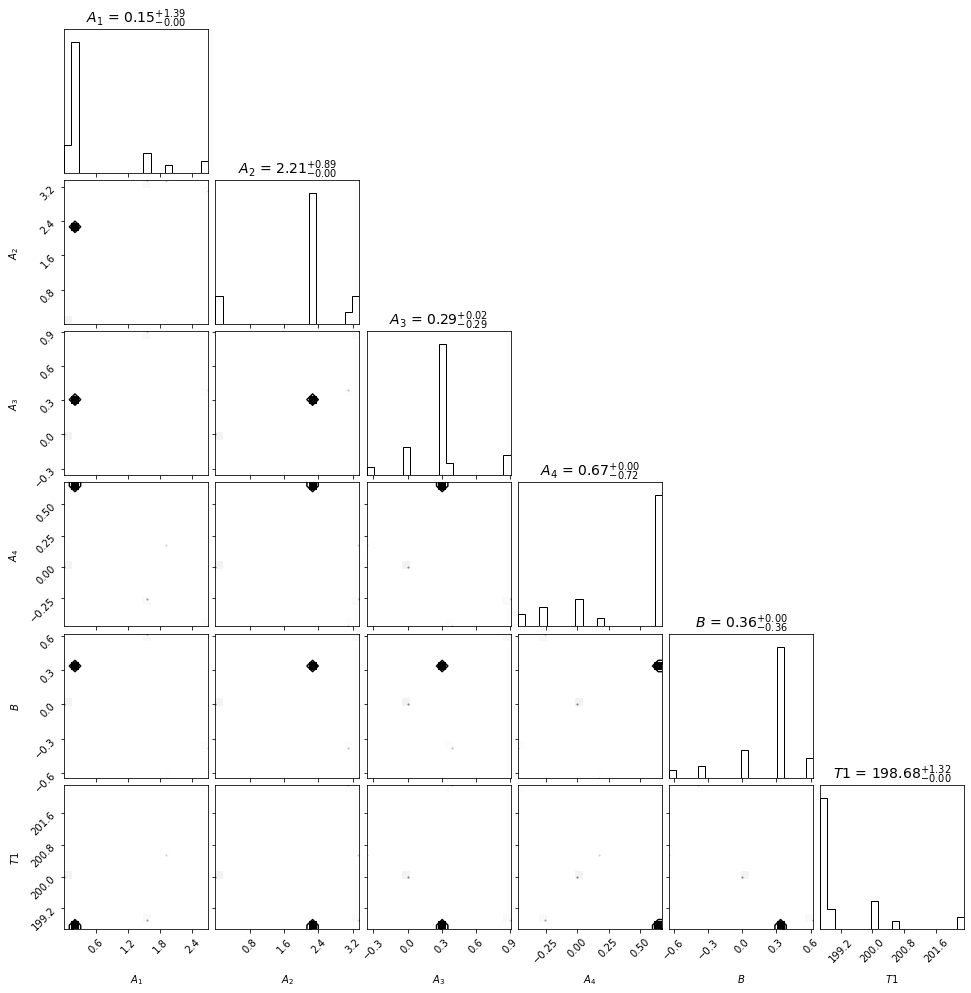

In [26]:
nsamples, ndim = samples.shape
figure = corner.corner(
    samples,
    labels=[
        r"$A_1$",
        r"$A_2$",
        r"$A_3$",
        r"$A_4$",
        r"$B$",
        r"$T1$"],
    show_titles=True,
    title_kwargs={"fontsize": 14},
)
params = np.mean(samples, axis = 0)

#### From pset02, the MLE estimates obtained were:
#### A1 = 2.061, A2 = 2.314, A3 = 0.034, A4 = 0.097, B = -0.071, T1 = 256.0

## Q2. Plotting residuals for 10th dataset from pset02

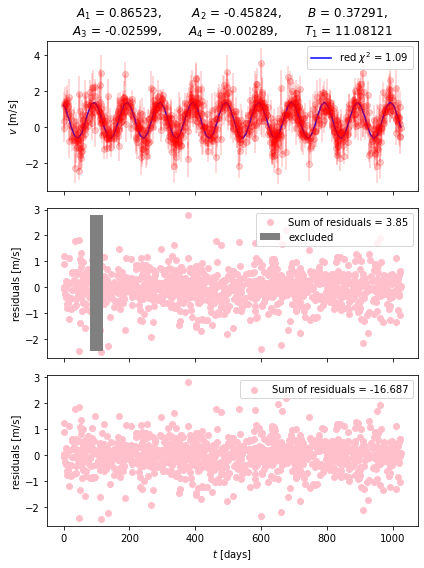

In [3]:
X_data = df[:,0]
Y_data_err = df[:,1]
Y_data = df[:,-2]
    
fig, ax = plt.subplots(3,1,sharex=True, figsize=(6,8))
ax[0].errorbar(X_data,Y_data,yerr = Y_data_err, marker = 'o', c = 'red', alpha = 0.2)
    
T0 = 100
def chi_sq(params):
    A1, A2, B, A3, A4, T1 = params[0], params[1], params[2], params[3], params[4], params[5]
    y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B +\
             A3*np.cos(2*np.pi*X_data[i]/T1) + A4*np.sin(2*np.pi*X_data[i]/T1)\
            for i in range(len(X_data))]
    func_list = [(Y_data[i]-y_fit[i])**2/Y_data_err[i]**2 for i in range(len(X_data))]
    ans = np.sum(func_list)
    return ans

p0 = [0.00895929795939929, -0.0009323793740367533, 0.0050815233784881515, 0.0016749338128239188, 0.024388859545279164, 11.0] #use close-enough initial estimates
LL_model = minimize(chi_sq, np.array(p0), method = 'L-BFGS-B')
A1, A2, B, A3, A4, T1 = LL_model.x[0], LL_model.x[1], LL_model.x[2], LL_model.x[3], LL_model.x[4], LL_model.x[5]

#deal with uncertainties
covar = LL_model.hess_inv
covar = covar * np.identity(covar.shape[1]) 

y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B +\
         A3*np.cos(2*np.pi*X_data[i]/T1) + A4*np.sin(2*np.pi*X_data[i]/T1)\
            for i in range(len(X_data))]
ax[0].plot(X_data, y_fit, 'b-', label = r'red $\chi^2$ = {}'.format(round((chi_sq([A1, A2, B, A3, A4, T1])/(len(X_data) -1)),2)))

str1 = r'$A_1$ = {},'.format(round(A1,5)) + '\t'
str2 = r'$A_2$ = {},'.format(round(A2,5)) + '\t'
str3 = r'$B$ = {},'.format(round(B,5)) + '\n'
str4 = r'$A_3$ = {},'.format(round(A3,5)) + '\t'
str5 = r'$A_4$ = {},'.format(round(A4,5)) + '\t'
str6 = r'$T_1$ = {}'.format(round(T1,5))

#plot residuals
Y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B +\
         A3*np.cos(2*np.pi*X_data[i]/T1) + A4*np.sin(2*np.pi*X_data[i]/T1)\
        for i in range(len(X_data))]

res = [Y_fit[i]-Y_data[i] for i in range(len(X_data))]
T_excl = np.append(np.linspace(1,80,80), np.linspace(120,400,281))
res_excl = [Y_fit[int(i)]-Y_data[int(i)] for i in T_excl]
sum_of_res = np.sum(res) #whole dataset
sum_of_res_excl = np.sum(res_excl) #excluding area around T=100

ax[1].scatter(X_data, res, marker = 'o', c = 'pink', label = 'Sum of residuals = {}'.format(round(sum_of_res_excl,3)))
rectangle = patches.Rectangle((80, min(res_excl)), 40, abs(max(res_excl) - min(res_excl)), edgecolor='None',\
                              facecolor="gray", zorder=2, label = 'excluded')
ax[1].add_patch(rectangle)
ax[2].scatter(X_data, res, marker = 'o', c = 'pink', label = 'Sum of residuals = {}'.format(round(sum_of_res,3)))

ax[0].set_title(str1 + str2 + str3 + str4 + str5 + str6)
ax[0].set_ylabel(r'$v$ [m/s]')
ax[1].set_ylabel(r'residuals [m/s]')
ax[2].set_ylabel(r'residuals [m/s]')
ax[2].set_xlabel(r'$t$ [days]')
ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.tight_layout()

#### We expect sum of residuals to be small for a good model. When excluding the zone near T=100, the sum decreases, which may not mean anything at all! At any rate, considering the number of datapoints, the sum is small.